In [1]:
import os
def homePath(path):
    if path[0] == "~":
        return os.path.join(os.path.expanduser("~"), path.strip("~/"))
    else:
        return path

#Model Creation 1
#Figure out how to do versioning effectively
individualInput = False
combinedInputPath = "/mnt/SPDrive/SPGenerations/"
pathToTokenizedData = "C:\\Users\\mcall\\OneDrive\\Desktop\\DummyOutput\\Tokenizer\\"
pathToGradeData = "C:\\Users\\mcall\\OneDrive\\Desktop\\DummyOutput\\Grader\\"
GradesTokensName = "1699020236"


if not individualInput:
    pathToTokenizedData = os.path.join(combinedInputPath, "Tokens/")
    pathToGradeData = os.path.join(combinedInputPath, "Grades/")

if GradesTokensName == "":
    #Use newest folder for each

    #Get the newest folder for the tokens
    tokensFolders = os.listdir(pathToTokenizedData)
    tokensFolders.sort()
    pathToTokenizedData = os.path.join(pathToTokenizedData , tokensFolders[-1])

    #Get the newest folder for the grades
    gradesFolders = os.listdir(pathToGradeData)
    gradesFolders.sort()
    pathToGradeData = os.path.join(pathToGradeData,  gradesFolders[-1])
else:
    pathToTokenizedData = os.path.join(pathToTokenizedData, GradesTokensName)
    pathToGradeData = os.path.join(pathToGradeData, GradesTokensName)





modelOutputPath = "/mnt/SPDrive/SPGenerations/Models/"



In [2]:
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Dropout, Bidirectional, Input, Flatten, Concatenate
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Model
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import keras.layers as layers
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Model




from keras.utils import pad_sequences
import os



#Load the data
#tokenized data is in tokenizedData.pkl, has tokenizer obj in tokenizer.json

#Load the tokenizer
with open(pathToTokenizedData+ "/tokenizer.json", "r") as f:
    tokenizer = tokenizer_from_json(f.read())



#Load the tokenized data
with open(pathToTokenizedData + "/tokenizedData.pkl", "rb") as f:
    tokenizedData = pickle.load(f)

#Load the grade data
#gradeData is a dict with keys as the file names and values as the grades
with open(pathToGradeData + "/grades.pkl", "rb") as f:
    gradeData = pickle.load(f)

#load the group data
#with open(pathToTokenizedData + "/tokenGroupDataframe.pkl", "rb") as f:
#    tokenizedGroupData = pickle.load(f)

combinedDF = pd.merge(tokenizedData, gradeData, on = "Path")
#combinedDF = pd.merge(combinedDF, tokenizedGroupData, on = "Path")
print (combinedDF)







2023-11-28 01:57:51.584543: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 01:57:51.620306: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 01:57:51.620330: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 01:57:51.620355: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 01:57:51.627684: I tensorflow/core/platform/cpu_feature_g

                                                tokenCode  \
0       [19, 10, 19, 45, 433, 29, 621, 6, 743, 6, 652,...   
1       [19, 10, 19, 45, 433, 29, 621, 6, 743, 6, 652,...   
2       [19, 10, 19, 45, 433, 29, 621, 6, 743, 6, 652,...   
3       [19, 10, 19, 45, 433, 29, 621, 6, 743, 6, 652,...   
4       [19, 10, 19, 45, 433, 29, 621, 6, 743, 6, 652,...   
...                                                   ...   
181828  [29, 681, 45, 291, 29, 291, 29, 1, 29, 272, 45...   
181829  [29, 681, 45, 291, 29, 291, 29, 1, 29, 272, 45...   
181830  [29, 681, 45, 291, 29, 291, 29, 1, 29, 272, 45...   
181831  [45, 291, 29, 291, 29, 1, 29, 272, 45, 1, 29, ...   
181832  [29, 681, 45, 291, 29, 291, 29, 1, 29, 272, 45...   

                                                     Path  fileGrade  
0       3722273/examples/basics/linear_regression.py/1.py  59.000000  
1       3722273/examples/basics/linear_regression.py/3.py  67.000000  
2       3722273/examples/basics/linear_regression.py/0

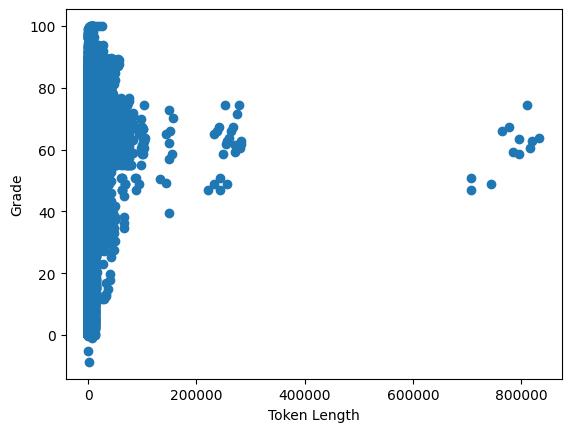

KeyboardInterrupt: 

In [ ]:
#chart of token length vs grade
tokenLengths = combinedDF["tokenCode"].apply(lambda x: len(x))
plt.scatter(tokenLengths, combinedDF["fileGrade"])
plt.xlabel("Token Length")
plt.ylabel("Grade")
plt.show()


#graph the density of the grades vs length
count = []
countLow = []
countHigh = []
for i in range(1, combinedDF["tokenCode"].apply(lambda x: len(x)).max() + 1):
    count.append(combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) == i]["fileGrade"].mean())
    countLow.append(combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) == i]["fileGrade"].quantile(.25))
    countHigh.append(combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) == i]["fileGrade"].quantile(.75))

                 

plt.scatter(range(1, combinedDF["tokenCode"].apply(lambda x: len(x)).max() + 1), count)
#draw a line of best fit
z = np.polyfit(range(1, combinedDF["tokenCode"].apply(lambda x: len(x)).max() + 1), count, 1)
p = np.poly1d(z)
plt.xlabel("Token Length")
plt.ylabel("Grade")
plt.show()







In [3]:
#Padding

maxLen = 500
minLen = 100
#get rid of the ones that are too long
combinedDF = combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) <= maxLen]
#combinedDF = combinedDF[combinedDF["tokenGroupCode"].apply(lambda x: len(x)) <= maxLen]
 

#get rid of the ones that are too short
combinedDF = combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) > minLen]
#combinedDF = combinedDF[combinedDF["tokenGroupCode"].apply(lambda x: len(x)) > minLen]

#Pad the sequences
combinedDF["tokenCode"] = pad_sequences(combinedDF["tokenCode"], maxlen = maxLen, padding = "post", truncating = "post").tolist()
#combinedDF["tokenGroupCode"] = pad_sequences(combinedDF["tokenGroupCode"], maxlen = maxLen, padding = "post", truncating = "post").tolist()

print (combinedDF)

#only use 5% of the dat
#combinedDF = combinedDF.sample(frac = 0.001, random_state = 1)

#48590 



                                                tokenCode  \
0       [19, 10, 19, 45, 433, 29, 621, 6, 743, 6, 652,...   
1       [19, 10, 19, 45, 433, 29, 621, 6, 743, 6, 652,...   
2       [19, 10, 19, 45, 433, 29, 621, 6, 743, 6, 652,...   
3       [19, 10, 19, 45, 433, 29, 621, 6, 743, 6, 652,...   
4       [19, 10, 19, 45, 433, 29, 621, 6, 743, 6, 652,...   
...                                                   ...   
181818  [45, 433, 29, 1, 4, 22, 9, 3, 10, 3, 4, 25, 9,...   
181819  [45, 433, 29, 1, 29, 272, 29, 83, 4, 22, 9, 3,...   
181820  [45, 433, 29, 1, 4, 22, 9, 3, 10, 3, 4, 25, 9,...   
181821  [45, 433, 29, 1, 29, 83, 4, 22, 9, 3, 10, 3, 4...   
181822  [45, 433, 29, 1, 4, 22, 9, 3, 10, 3, 4, 25, 9,...   

                                                     Path  fileGrade  
0       3722273/examples/basics/linear_regression.py/1.py  59.000000  
1       3722273/examples/basics/linear_regression.py/3.py  67.000000  
2       3722273/examples/basics/linear_regression.py/0

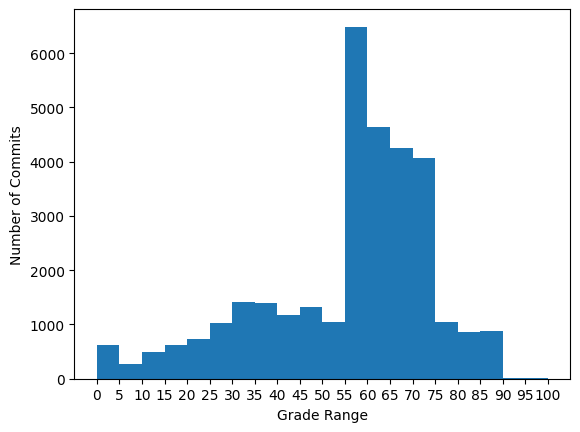

In [6]:
#create a chart of the grades
graph = plt.hist(combinedDF['fileGrade'], bins=20, range=(0, 100))
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.xlabel("Grade Range")
plt.ylabel("Number of Commits")
plt.show()



In [ ]:
#test to make sure gpu is detected and save as bool
gpu_detected = tf.test.is_gpu_available()


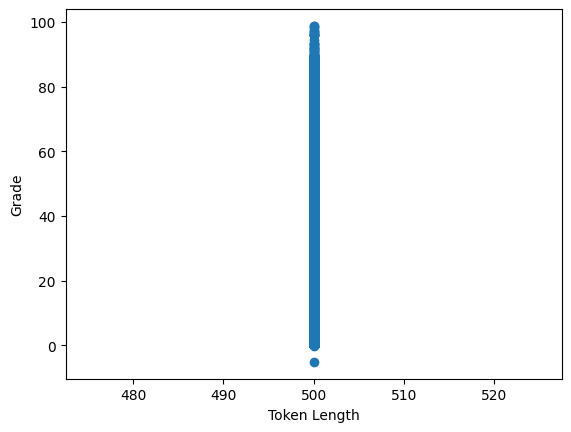

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 500, 1024)         819200    
                                                                 
 conv1d_2 (Conv1D)           (None, 498, 2048)         6293504   
                                                                 
 global_max_pooling1d_2 (Gl  (None, 2048)              0         
 obalMaxPooling1D)                                               
                                                                 
 reshape_2 (Reshape)         (None, 1, 2048)           0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 1, 2048)           25174016  
 onal)                                                     

/home/mcall/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/TokenizerManager.py
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/CaMlSupportingClasses.py
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/PythonProcessing.py
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/CaMlSupportingClasses.cpython-310.pyc
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/CodeSimilarization.cpython-310.pyc
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/PythonProcessing.cpython-310.pyc
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/TokenProcessing.cpython-310.pyc
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/TokenProcessing.py
/home/mcall/SP

tar: Removing leading `/' from member names
tar: Removing leading `/home/mcall/SPGit/Model-Generation/../' from member names


KeyError: 'val_loss'

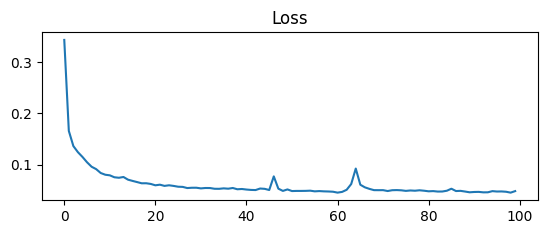

In [6]:
#if (not gpu_detected):
#    print("GPU not detected, using CPU")


#Create the model
#Input
inputTokens = layers.Input(shape=(maxLen,), dtype='int32')

#Embedding
embedding = layers.Embedding(tokenizer.num_words, 1024, input_length=maxLen)(inputTokens)

#Convolutional
convolutional = layers.Conv1D(2048, 3, activation='relu')(embedding)
convolutional = layers.GlobalMaxPooling1D()(convolutional)
convolutional = layers.Reshape((1, 2048))(convolutional)

#LSTM
lstm = layers.Bidirectional(LSTM(1024, return_sequences=True))(convolutional)
lstm = Dropout(0.38479930887149405)(lstm)
lstm = layers.Bidirectional(LSTM(512))(lstm)

#Dense
dense = layers.Flatten()(lstm)
dense = layers.Dense(2048, activation='relu')(dense)
dense = layers.Dense(1024, activation='relu')(dense)
dense = layers.Dense(512, activation='relu')(dense)
dense = layers.Dense(256, activation='relu')(dense)
dense = layers.Dense(128, activation='relu')(dense)
dense = layers.Dense(64, activation='relu')(dense)
dense = layers.Dense(32, activation='relu')(dense)
dense = layers.Dense(16, activation='relu')(dense)
dense = layers.Dense(8, activation='relu')(dense)
dense = layers.Dense(4, activation='relu')(dense)
dense = layers.Dense(2, activation='relu')(dense)
dense = layers.Dense(1, activation='relu')(dense)

#Output
output = dense


model = Model(inputs=inputTokens, outputs=output)



print(model.summary())

model.compile(loss='mean_squared_logarithmic_error', optimizer='Adam', metrics=['mse', 'mae', 'mape', 'accuracy'])





# convert inputs to numpy arrays
token_code = np.array(combinedDF["tokenCode"].tolist())
file_grade = np.array(combinedDF["fileGrade"].tolist())


hist = model.fit(token_code, file_grade, epochs=100, batch_size=32, verbose=1)


#Save the model in timestamp folder and with tokenizer
timestamp = str(pd.Timestamp.now()).replace(" ", "_").replace(":", "-").replace(".", "-")
if not os.path.exists(modelOutputPath):
    os.mkdir(modelOutputPath)
if not os.path.exists(modelOutputPath + "/" + timestamp):
    os.mkdir(modelOutputPath + "/" + timestamp)
model.save(modelOutputPath + "/" + timestamp + "/model.h5")
with open(modelOutputPath + "/" + timestamp + "/tokenizer.json", "w") as f:
    f.write(tokenizer.to_json())
#make an archaive of the SCA-Tokenizer Folder
#get CWD
cwd = os.getcwd()
if os.path.exists(os.path.join(cwd, "SCA-Tokenizer")):
    os.system("tar -czvf \"" + modelOutputPath + "/" + timestamp + "/SCA-Tokenizer.tar.gz\" " + os.path.join(cwd, "SCA-Tokenizer"))

#Save the AutoGrader Folder
autoGraderDir = os.path.join(cwd, "../Auto-Grader/")
if os.path.exists(autoGraderDir):
    os.system("tar -czvf \"" + modelOutputPath + "/" + timestamp + "/Auto-Grader.tar.gz\" " + autoGraderDir)

#Save tokenizedGroupData
#copy GroupDict.npy from the tokenizer folder to the model folder
if os.path.exists(os.path.join(cwd, "SCA-Tokenizer", "GroupDict.npy")):
    os.system("cp " + os.path.join(cwd, "SCA-Tokenizer", "GroupDict.npy") + " " + os.path.join(modelOutputPath, timestamp, "GroupDict.npy"))



plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
#Save the model in timestamp folder and with tokenizer
timestamp = str(pd.Timestamp.now()).replace(" ", "_").replace(":", "-").replace(".", "-")
if not os.path.exists(modelOutputPath):
    os.mkdir(modelOutputPath)
if not os.path.exists(modelOutputPath + "/" + timestamp):
    os.mkdir(modelOutputPath + "/" + timestamp)
model.save(modelOutputPath + "/" + timestamp + "/model.h5")
with open(modelOutputPath + "/" + timestamp + "/tokenizer.json", "w") as f:
    f.write(tokenizer.to_json())
#make an archaive of the SCA-Tokenizer Folder
#get CWD
cwd = os.getcwd()
if os.path.exists(os.path.join(cwd, "SCA-Tokenizer")):
    os.system("tar -czvf \"" + modelOutputPath + "/" + timestamp + "/SCA-Tokenizer.tar.gz\" " + os.path.join(cwd, "SCA-Tokenizer"))

#Save the AutoGrader Folder
autoGraderDir = os.path.join(cwd, "../Auto-Grader/")
if os.path.exists(autoGraderDir):
    os.system("tar -czvf \"" + modelOutputPath + "/" + timestamp + "/Auto-Grader.tar.gz\" " + autoGraderDir)

In [3]:
import os
timestamp = str(pd.Timestamp.now()).replace(" ", "_").replace(":", "-").replace(".", "-")
if not os.path.exists(modelOutputPath):
    os.mkdir(modelOutputPath)
if not os.path.exists(modelOutputPath + "/" + timestamp):
    os.mkdir(modelOutputPath + "/" + timestamp)

In [12]:
# assuming `model` is your Keras model
#convert inputs to numpy arrays



[(None, 33), (None, 33)]
[29, 384, 45, 374, 29, 1, 6, 1, 45, 374, 5, 1, 29, 1, 7, 142, 6, 176, 8, 9, 7, 1, 5, 142, 6, 1, 5, 176, 8, 82, 30, 22, 7, 384, 5, 1, 8, 11, 2, 18, 14, 22, 7, 12, 8, 11, 2, 2, 12, 5, 102, 7, 142, 6, 3, 10, 3, 8, 2, 2, 12, 5, 102, 7, 176, 6, 3, 10, 3, 8, 2, 2, 12, 5, 1, 7, 176, 6, 3, 10, 3, 8, 2, 2, 12, 5, 1, 7, 142, 6, 3, 10, 3, 8, 2, 2, 12, 5, 1, 7, 176, 6, 13, 8, 2, 2, 12, 5, 1, 7, 142, 6, 13, 8, 2, 2, 12, 5, 1, 7, 142, 6, 176, 8, 2, 18, 14, 25, 7, 12, 8, 11, 2, 2, 12, 5, 102, 7, 1, 7, 176, 8, 6, 142, 8, 2, 2, 12, 5, 102, 7, 1, 7, 142, 8, 6, 176, 8, 2, 18, 14, 26, 7, 12, 8, 11, 2, 2, 12, 5, 330, 7, 125, 6, 1, 6, 3, 10, 3, 8, 2, 18, 14, 28, 7, 12, 8, 11, 2, 2, 12, 5, 102, 7, 1, 7, 3, 10, 3, 8, 6, 7, 8, 8, 2, 2, 12, 5, 102, 7, 1, 7, 3, 10, 3, 8, 6, 7, 142, 6, 8, 8, 2, 2, 12, 5, 102, 7, 1, 7, 3, 10, 3, 8, 6, 7, 142, 6, 176, 6, 176, 6, 142, 8, 8, 2, 18, 14, 31, 7, 12, 8, 11, 2, 2, 12, 5, 330, 7, 125, 6, 1, 6, 3, 10, 3, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 